In [ ]:
#!pip install shap --upgrade
#!pip uninstall -y azureml-interpret

In [ ]:
#!pip install pandas-profiling

In [ ]:
#!pip install seaborn

In [ ]:
#Based on the following article
#https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

In [1]:
#from pandas_profiling import ProfileReport
from azureml.core import Experiment
from azureml.core import Workspace, Dataset

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc("font", size=14)
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)





In [3]:
import shap
shap.initjs()

In [4]:
subscription_id = '6ed9d167-b2e6-41b8-9500-35e6df64d9dc'
resource_group = 'MLRG'
workspace_name = 'erbbimlws'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='Primary_Bank')
df = dataset.to_pandas_dataframe()

In [5]:
experiment = Experiment(workspace = workspace, name = "Logistic_Regression_on_Primary_Bank")

In [6]:
run = experiment.start_logging(snapshot_directory=None)

In [7]:
pd.set_option('max_columns', None) #display all columns
#pd.reset_option(“max_columns”) #to return to default

In [ ]:
df.head()

<AxesSubplot:title={'center':'New_Primary_Bank_Flag'}, ylabel='New_Primary_Bank_Flag'>

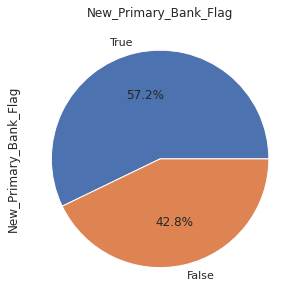

In [8]:
df['New_Primary_Bank_Flag'].value_counts().plot(kind = 'pie',y = 'New_Primary_Bank_Flag',figsize=(5, 5),title = 'New_Primary_Bank_Flag',autopct='%1.1f%%')


In [9]:
df = df.drop(columns = ['Customer_ID','Year','Month','Legal_Person', 'Active_Customer', 'Priority_Segment',	'Primary_Bank','Group_Sales_Group_Code'])

In [10]:
def binF(x):
    if x is False:
        z = 0
    elif math.isnan(x):
        z = 0
    else:
        z =1
    return z

In [11]:
df['New_Primary_Bank_Flag'] = df['New_Primary_Bank_Flag'].apply(binF)

In [12]:
#dummy variables
for col in df.columns:       
       if df[col].dtypes=='object':
            df = pd.get_dummies(df, prefix=col + '_', columns=[col])
    

In [13]:
for col in df.columns:       
       if df[col].dtypes=='datetime64[ns]':
            df = df.drop(columns = col)


In [23]:
df_s = df.sample(frac=0.1)
#df_s = df

In [24]:
x_train, x_test, y_train, y_test = train_test_split(df_s.loc[:,df_s.columns !='New_Primary_Bank_Flag'].fillna(0), df_s['New_Primary_Bank_Flag'].fillna(0), test_size=0.25, random_state=0)



In [25]:
LR = LogisticRegression(penalty="l1", C=1.0,solver = 'liblinear',max_iter = 300)


In [26]:
rfe = RFE(LR, n_features_to_select= 100)

In [27]:
rfe = rfe.fit(x_train,y_train)

Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.
Liblinear failed to converge, increase the number of iterations.


In [29]:
x_train, x_test, y_train, y_test = train_test_split(df.loc[:,x_train.columns[rfe.support_]].fillna(0), df['New_Primary_Bank_Flag'].fillna(0), test_size=0.25, random_state=0)

In [31]:
x_train.columns

Index(['SB_Customer', 'Bucket_Max_1M', 'Bucket_Max_1Y',
       'Bucket_Months_Count_1Y', 'Remmitances_Out_nonGR_Num_Sum_1Y',
       'Remmitances_In_nonGR_Num_Sum_1Y', 'Rescheduling_Flag',
       'Credit_Trans_Num_Sum_6M', 'Debit_Trans_Days_Count_6M',
       'Branch_Trans_Days_Count_6M', 'ATM_Trans_Num_Sum_6M',
       'ATM_Trans_Days_Count_6M', 'Phone_Trans_Num_Sum_6M',
       'APS_Trans_Num_Sum_6M', 'Group_Sales_Payment_Months_Distinct_6M',
       'Trn_Deposit_Num_Sum_6M', 'Trn_InternalTransfer_Num_Sum_6M',
       'Trn_LoanCardPayment_Num_Sum_6M', 'Trn_TelecomPayment_Amount_Sum_6M',
       'Trn_OtherPrivateSectorPayments_Num_Sum_6M',
       'Trn_Taxpayments_Num_Sum_6M', 'Trn_MunicipalitiesPayment_Amount_Sum_6M',
       'EB_Trn_DEKO_Payments_Num_Sum_6M', 'EB_Trn_DEKO_Payments_Days_Count_6M',
       'EB_Trn_DOY_Payments_Days_Count_6M',
       'EB_Trn_Insurance_Payments_Days_Count_6M',
       'EB_Trn_Investment_Days_Count_6M', 'EB_Trn_Loan_Payment_Days_Count_6M',
       'EB_Trn_Out_Remmit

In [32]:
LR = LogisticRegression(penalty="l1", C=0.1,solver = 'liblinear')

In [33]:
LR.fit(x_train,y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [34]:
print(classification_report(y_train,  LR.predict(x_train)))

              precision    recall  f1-score   support

           0       0.76      0.72      0.74      7453
           1       0.80      0.83      0.81      9796

    accuracy                           0.78     17249
   macro avg       0.78      0.78      0.78     17249
weighted avg       0.78      0.78      0.78     17249



In [35]:
print('Accuracy of logistic regression classifier on train set: {:.4f}'.format(LR.score(x_train, y_train)))

Accuracy of logistic regression classifier on train set: 0.7841


In [36]:
print(classification_report(y_test,  LR.predict(x_test)))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72      2399
           1       0.79      0.84      0.81      3351

    accuracy                           0.78      5750
   macro avg       0.77      0.77      0.77      5750
weighted avg       0.78      0.78      0.78      5750



In [37]:
print('Accuracy of logistic regression classifier on test set: {:.4f}'.format(LR.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.7769


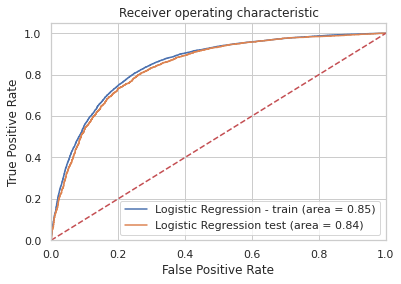

In [38]:
roc = plt.figure()
logit_roc_auc = roc_auc_score(y_train.to_numpy(), LR.predict(x_train))
fpr, tpr, thresholds = roc_curve(y_train.to_numpy(), LR.predict_proba(x_train)[:,1])
auc_train = roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='Logistic Regression - train (area = %0.2f)' % auc_train)

logit_roc_auc = roc_auc_score(y_test, LR.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, LR.predict_proba(x_test)[:,1])
auc_test = roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='Logistic Regression test (area = %0.2f)' % auc_test)

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")



In [39]:
roc.savefig('images/LG_ROC.jpg',bbox_inches='tight')
plt.close()
run.log_image('ROC','images/LG_ROC.jpg')

In [40]:
x = x_train.append(x_test, ignore_index=True)
y = y_train.append(y_test, ignore_index=True)

In [41]:
explainer = shap.Explainer(LR, x)
shap_values = explainer.shap_values(x)
x_array = x#.to_numpy() # we need to pass a dense version for the plotting functions

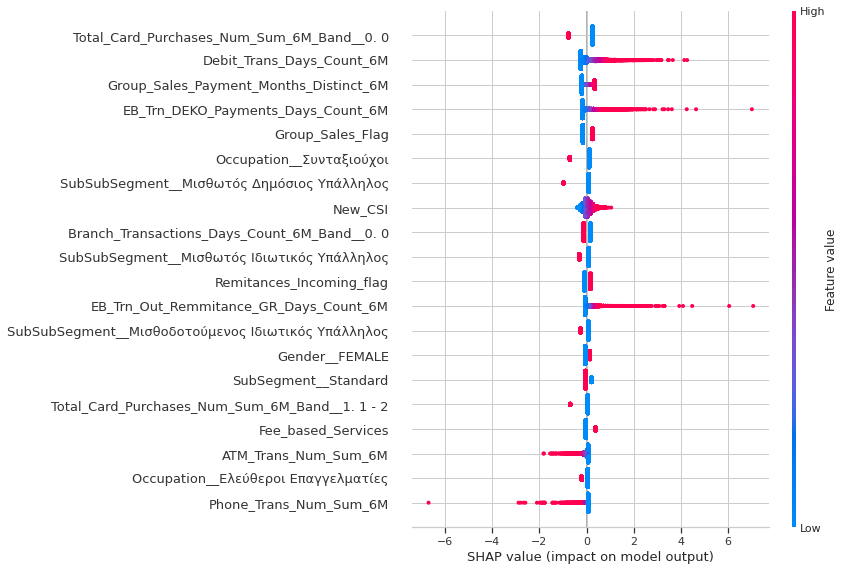

In [42]:
shap.summary_plot(shap_values, x_array,x.columns)


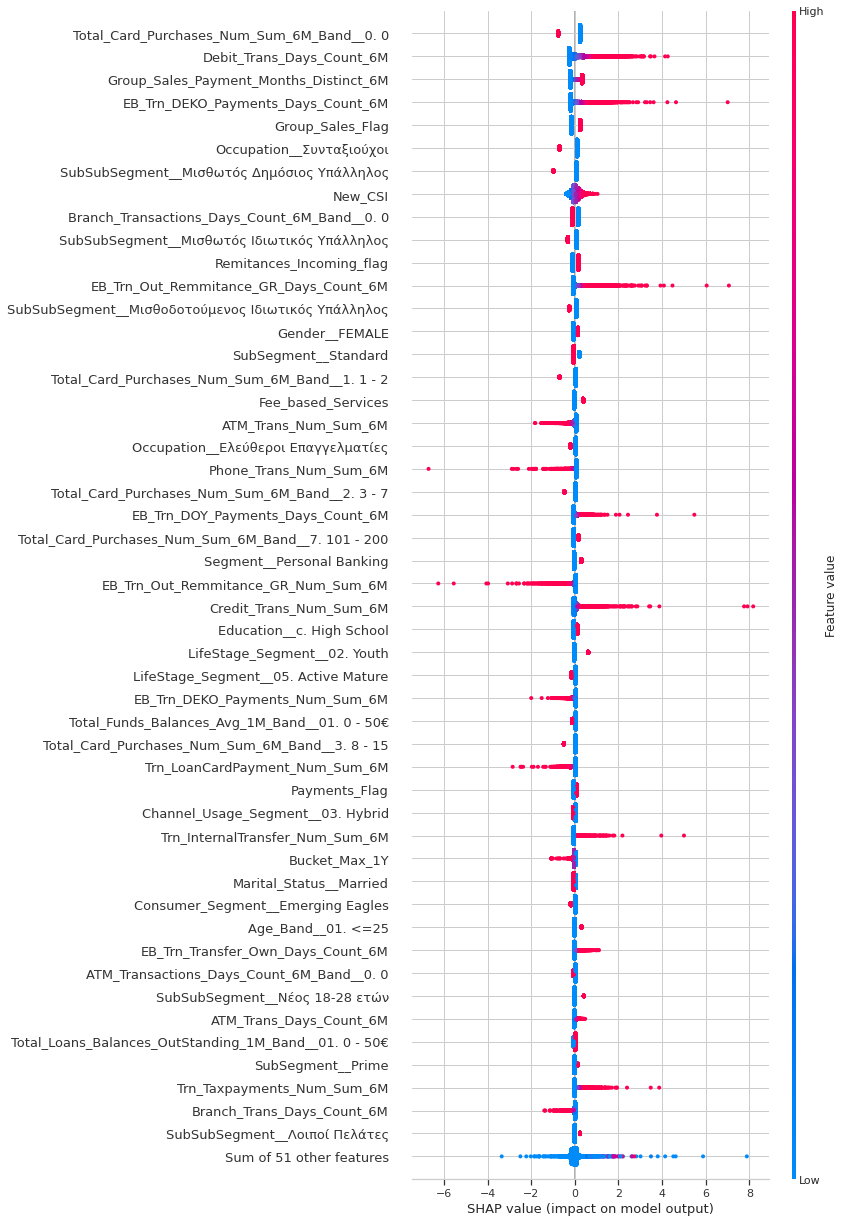

In [43]:
shap.plots.beeswarm(explainer(x),max_display =50)

In [ ]:
#odds = np.exp(LR.coef_[0])
#df_coef = pd.DataFrame(odds,x_test.columns,columns=['coef']).sort_values(by='coef', ascending=False)

In [ ]:
#pd.set_option("max_rows", None) #display all rows
#pd.reset_option('max_rows') #return to default settings

In [ ]:
#df_coef.head(20)

In [ ]:
#selected_features = pd.DataFrame(shap_values,columns =x.columns).aggregate(func = ['mean'],axis =0).T\
#    .apply(abs).sort_values(by='mean', ascending = False).head(30).index

In [ ]:
#selected_features.shape

In [44]:
run.complete()